In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import geemap
import geemap.colormaps as cm
import ee

import datetime
from pathlib import Path
from time import sleep
import io
from tqdm.notebook import tqdm

from sklearn.utils import shuffle

from multiprocessing import Pool

In [2]:
ee.Authenticate()
ee.Initialize(project='sentinel-treeclassification')

Data source:

https://figshare.com/collections/A_high-resolution_pan-European_tree_occurrence_dataset/3288407

In [4]:
df = pd.read_csv('EUForestspecies.csv')

In [5]:
df.shape

(588983, 10)

In [6]:
df.head()

,X,Y,COUNTRY,SPECIES NAME,DBH-1,DBH-2,NFI,FF,BS,EEO
0,4305500,2674500,Austria,Abies alba,-9999,-9999,-9999,1,-9999,1
1,4576500,2705500,Austria,Abies alba,1,1,1,-9999,-9999,1
2,4570500,2721500,Austria,Abies alba,1,1,1,-9999,-9999,1
3,4300500,2663500,Austria,Abies alba,-9999,1,1,-9999,-9999,1
4,4610500,2811500,Austria,Abies alba,-9999,1,1,-9999,-9999,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588983 entries, 0 to 588982
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   X             588983 non-null  int64 
 1   Y             588983 non-null  int64 
 2   COUNTRY       588983 non-null  object
 3   SPECIES NAME  588983 non-null  object
 4   DBH-1         588983 non-null  int64 
 5   DBH-2         588983 non-null  int64 
 6   NFI           588983 non-null  int64 
 7   FF            588983 non-null  int64 
 8   BS            588983 non-null  int64 
 9   EEO           588983 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 44.9+ MB


In [8]:
df[['X', 'Y']].value_counts()

X        Y      
4638500  2148500    24
4669000  2525000    24
3960500  2820000    22
4697000  2591000    22
4701000  2527500    20
                    ..
3250500  2339500     1
         2346500     1
         3446500     1
4294000  4295000     1
1551500  1033500     1
Name: count, Length: 250569, dtype: int64

<Axes: >

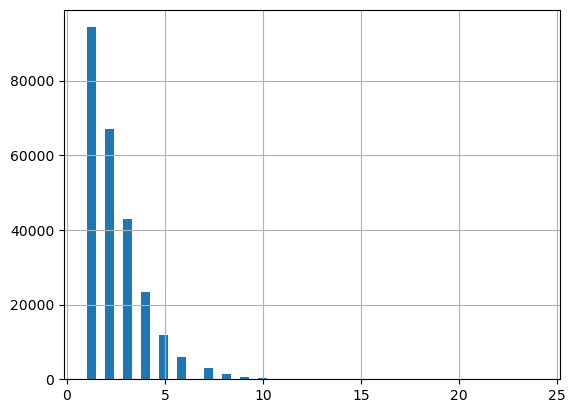

In [9]:
df[['X', 'Y']].value_counts().hist(bins=50)

In [10]:
df[['X', 'Y']].value_counts().shape

(250569,)

In [11]:
df['SPECIES NAME'].unique().shape

(242,)

In [12]:
df['SPECIES NAME'].value_counts()

SPECIES NAME
Pinus sylvestris          75720
Picea abies               70310
Fagus sylvatica           35862
Quercus robur             31079
Betula pubescens          26676
                          ...  
Frangula rupestris            1
Populus balsamifera           1
Salix daphnoides              1
Rhus typhina                  1
Tetraclinis articulata        1
Name: count, Length: 242, dtype: int64

<Axes: >

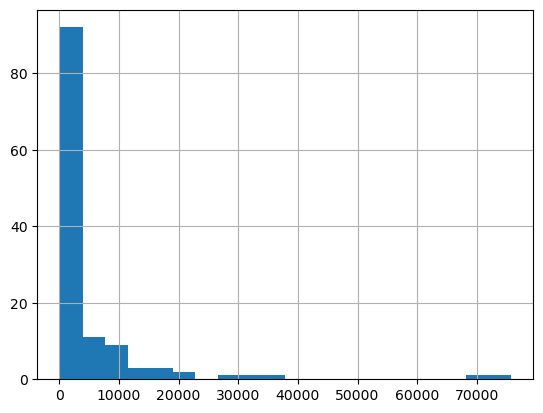

In [13]:
df['SPECIES NAME'].value_counts()[df['SPECIES NAME'].value_counts()>=100].hist(bins=20)

<Axes: >

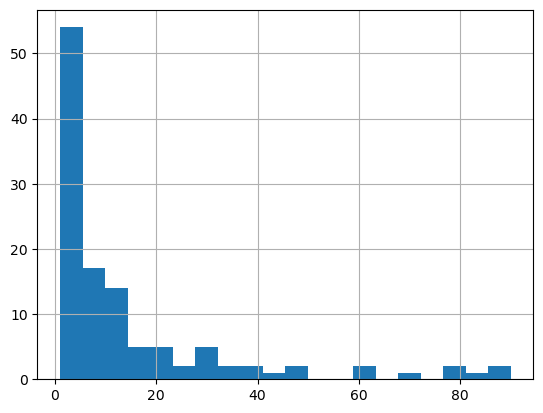

In [14]:
df['SPECIES NAME'].value_counts()[df['SPECIES NAME'].value_counts()<100].hist(bins=20)

In [15]:
grouped = df[['X', 'Y', 'SPECIES NAME']].groupby(['X', 'Y'], as_index=False).agg({'SPECIES NAME': ', '.join})

In [16]:
# grouped.to_csv('plots.csv', index=False)

In [17]:
grouped.shape

(250569, 3)

In [18]:
grouped.head()

,X,Y,SPECIES NAME
0,1551500,1033500,Pinus radiata
1,1552500,1032500,Pinus canariensis
2,1553500,1031500,Pinus canariensis
3,1553500,1032500,Pinus canariensis
4,1554500,1031500,Pinus canariensis


In [19]:
gdf = gpd.GeoDataFrame(
    grouped.drop(labels=['X', 'Y'], axis=1), 
    geometry=gpd.points_from_xy(x=grouped.X, y=grouped.Y, crs='EPSG:3035')
)
gdf.geometry = gdf.buffer(500, cap_style=3).to_crs(epsg=4326)

In [20]:
gdf.head()

,SPECIES NAME,geometry
0,Pinus radiata,"POLYGON ((-18.11660 27.73646, -18.11376 27.727..."
1,Pinus canariensis,"POLYGON ((-18.10417 27.73111, -18.10133 27.722..."
2,Pinus canariensis,"POLYGON ((-18.09174 27.72575, -18.08891 27.717..."
3,Pinus canariensis,"POLYGON ((-18.09458 27.73434, -18.09174 27.725..."
4,Pinus canariensis,"POLYGON ((-18.08215 27.72898, -18.07932 27.720..."


In [21]:
# Add some padding to avoid border polygons being cut off.
bbox = ee.Geometry.BBox(*(gdf.geometry.total_bounds + 0.01))

In [22]:
class SentinelGetter:
    def mask_s2_clouds(self, image):
      # Quality assessment with resolution in meters
      qa = image.select('QA60')
      # Bits 10 and 11 are clouds and cirrus, respectively.
      cloud_bit_mask = 1 << 10
      cirrus_bit_mask = 1 << 11
      # Both flags should be set to zero, indicating clear conditions.
      mask = (
          qa.bitwiseAnd(cloud_bit_mask)
          .eq(0)
          .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
      )
      return image.updateMask(mask)

    def get_image(self, bbox, start_date, end_date):
        selected_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12', 'TCI_R', 'TCI_G', 'TCI_B']
        image = (
            ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterDate(start_date, end_date)
            # .filter(ee.Filter.calendarRange(6, 9, 'month'))
            # Pre-filter to get less cloudy granules.
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
            .map(self.mask_s2_clouds)
            .select(selected_bands)
            .median()
            .clip(bbox)
        )
        return image

In [23]:
def visualise(gdf, bbox):
    rgb_bands = ['B4', 'B3', 'B2']
    visualization = {
        'min': 1,
        'max': 3000,
        'bands': rgb_bands
    }
    
    start_date = datetime.datetime(2017, 3, 1)
    end_date = datetime.datetime(2020, 3, 1)
    
    image = SentinelGetter().get_image(bbox, start_date, end_date)
    
    m = geemap.geemap.Map()
    
    center = (np.array(bbox.getInfo()['coordinates'][0][2]) + np.array(bbox.getInfo()['coordinates'][0][0]))/2
    
    m.set_center(*center, 7)
    
    style = {"stroke": True, "color": "green",
             "weight": 2, "opacity": 1, "fillOpacity": 0.1
    }
    
    m.add_gdf(gdf, layer_name='euforest', style=style)
    
    m.addLayer(image, visualization, 'RGB')
    
    earth_url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
    m.add_tile_layer(earth_url, name='Google Earth', attribution='Google')
    
    m.addLayerControl(position='topright')
    return m
# visualise(gdf.sample(5000), bbox)

Although it wouldn't matter for training purposes, the centering of each cell matters for comparisons with, e.g TreeSatAI. I expected all EU Forest data to be centered at midway points of 1 km cells, so all coordinates would end with 500 instead of 000. As shown below, that's not the case entirely.

In [24]:
uncentered_mask = (grouped['X'] % 1000 != 500) | (grouped['Y'] % 1000 != 500)
uncentered_mask.sum()

7666

In [25]:
# visualise(gdf[uncentered_mask], bbox)

In [26]:
def download_npy(ith_chunk, chunk, chunk_size, bbox, start_date, end_date, features_dir):
    # Sleep time helps with parallel processing,
    # if you're brave enough to try it
    sleep_time = ith_chunk%10
    sleep(sleep_time)

    chunk_fragments = chunk.shape[0]

    # Check if this chunk's download has been completed
    total_shards = 0
    for n in range(chunk_fragments):
        shard_id = ith_chunk*chunk_size + n
        s = features_dir.joinpath(f'feature_{ith_chunk*chunk_size + n}.npy')
        if s.is_file() and (s.stat().st_size == 1040128):
            total_shards += 1
    if total_shards == chunk_fragments:
        return

    # Cloud masked, band selected, mean image of the bbox area. 
    sentinel_image = SentinelGetter().get_image(bbox, start_date, end_date)
        
    # For further options, see
    # https://developers.google.com/earth-engine/apidocs/ee-data-computepixels
    params = {'fileFormat': 'NPY'}

    print(f'Downloading chunk {ith_chunk}', flush=True)
    all_data = []
    
    # Progress bar, tracks continuations
    for _, row in tqdm(chunk.iterrows(), total=chunk_fragments):
        # Not ideal but a lot of connection errors can occur here.
        # They are (so far) not program ending, simply retry.
        retry = True
        while retry:
            try:
                this_bbox = ee.Geometry.BBox(*row.geometry.bounds)
                params['expression'] = sentinel_image.clipToBoundsAndScale(
                    this_bbox, width=100, height=100)

                # There can be a delay before the URL becomes available,
                # in which case the loop simply retries (seems rare so far).
                pixels = ee.data.computePixels(params)
                data = np.load(io.BytesIO(pixels))

                # Numpy ndarray being appended to a list of ndarrays.
                # Ensure all_data uses python's list instead of ndarray.tolist().
                all_data.append(data)
                retry = False
                
            except Exception as e:
                print(e)
                # Sleep for 1 second if error, Google seems
                # fine with 100/s requests.
                sleep(sleep_time)
                retry = True
                
    raw_features = np.array(all_data)
    features = raw_features.view((float, len(raw_features.dtype.names)))
    features[..., :-3] = features[..., :-3]/10000
    features[..., -3:] = features[..., -3:]/255
    
    for ii in range(chunk_fragments):
        shard_id = ith_chunk*chunk_size + ii
        np.save(
            features_dir.joinpath(f'feature_{shard_id}.npy'), 
            features[ii, ...]
        )

In [27]:
dummy_labels = gdf['SPECIES NAME'].str.get_dummies(sep=', ').astype(float)
dummy_gdf = dummy_labels.join(gdf['geometry'])
dummy_gdf.drop('geometry', axis=1).to_csv('full_dummies.csv', index=False)

In [29]:
parent_dir = Path.home().joinpath('sentinel_data')
shards_dir = parent_dir.joinpath('shards')

start_date = datetime.datetime(2020, 3, 1)

def run_jobs(shards_dir, dummy_gdf, bbox, start_date):
    chunk_size = 100
    chunks = [dummy_gdf[i: i + chunk_size] for i in range(0, dummy_gdf.shape[0], chunk_size)]
    map_inputs = []
    
    labels_dir = shards_dir.joinpath(f'labels')
    labels_dir.mkdir(exist_ok=True)

    if len(list(labels_dir.glob('*'))) != dummy_gdf.shape[0]:
        for shard_id, row in dummy_gdf.drop('geometry', axis=1).iterrows():
            np.save(
                labels_dir.joinpath(f'label_{shard_id}.npy'), 
                row.to_numpy()
            )
            
    while start_date < datetime.datetime(2020, 6, 1):
        date_tag = f'{start_date.year}{str(start_date.month).zfill(2)}'
        features_dir = shards_dir.joinpath(f'features_{date_tag}')
        features_dir.mkdir(exist_ok=True)
        
        end_month = (start_date.month + 3)%12 or 12
        end_date = start_date.replace(
            month=end_month, 
            year=start_date.year + (start_date.month + 3)//13)

        for ith_chunk, chunk in enumerate(chunks[:2]):
            map_inputs.append((ith_chunk, chunk, chunk_size, bbox, start_date, end_date, features_dir))
            
        start_date = end_date
        
    pool = Pool(processes=6)
    pool.starmap(download_npy, tqdm(map_inputs, total=len(map_inputs)), chunksize=1)
    pool.close()
    pool.join()
    
run_jobs(shards_dir, dummy_gdf, bbox, start_date)

In [ ]:
# import subprocess
# subprocess.run(['sudo', 'shutdown', 'now'])